## EXPERIMENT 1: MagFace

In [35]:
## Load libraries

import numpy as np
import cv2
from matplotlib import pyplot as plt
import torch
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import normalize
import sys
sns.set(style="white")
%matplotlib inline
sys.path.append('../../utils')
from Model_utils.Model_funcs import *
from Result_metric_utils.result_metrics import *
from Data_proc_utils.Data_proc_funcs import *
from DET_utils.DET_plots import *
from DET_utils.DET import *
from Plotting_stats_utils.plotting_threshold import *
from Plotting_stats_utils.stats_tables import *
from IPython import embed


### MagFace Results

This notebook loads the feature vectors from MagFace and run them through the results metrics:
FNIR, FPIR, FND, FPD, and GARBE

# Load data

In [52]:
feature_list_children = '../../data/data_full/feature_vectors/magface_feature_vectors/2.1/feature_vectors_from_children_bibel_all_finetuning_ex_2_1.list'
feature_list_adults = '../../data/data_full/feature_vectors/magface_feature_vectors/2.1/feature_vectors_from_adults_bibel_cropped_retina_all_finetuning_ex_2_1.list'

def load_and_compute_similarity(feature_list, dtype=np.float32):
    # Load data
    image_names, ids, num_ids, norm_feats = load_magface_vectors(feature_list)

    # Convert dtype to reduce memory usage
    norm_feats = norm_feats.astype(dtype)

    # Compute similarity matrix incrementally if possible
    sim_mat = np.dot(norm_feats, norm_feats.T)

    return image_names, ids, num_ids, sim_mat


In [53]:
# Load and compute for children
image_names_c, ids_c, num_ids_c, sim_mat_c = load_and_compute_similarity(feature_list_children)


/data/data_full/children_full_filtered_age_std/Indian_682/Indian_682_11.png
/data/data_full/children_full_filtered_age_std/Indian_682/Indian_682_8.png
/data/data_full/children_full_filtered_age_std/Indian_682/Indian_682_34.png
/data/data_full/children_full_filtered_age_std/Indian_682/Indian_682_32.png
/data/data_full/children_full_filtered_age_std/Indian_682/Indian_682_26.png
/data/data_full/children_full_filtered_age_std/Indian_682/Indian_682_2.png
/data/data_full/children_full_filtered_age_std/Asian_119/Asian_119_18.png
/data/data_full/children_full_filtered_age_std/Asian_119/Asian_119_28.png
/data/data_full/children_full_filtered_age_std/Asian_119/Asian_119_39.png
/data/data_full/children_full_filtered_age_std/Asian_119/Asian_119_25.png
/data/data_full/children_full_filtered_age_std/Asian_119/Asian_119_45.png
/data/data_full/children_full_filtered_age_std/Caucasian_105/Caucasian_105_49.png
/data/data_full/children_full_filtered_age_std/Caucasian_1197/Caucasian_1197_7.png
/data/data_

In [54]:

# Load and compute for adults
image_names_a, ids_a, num_ids_a, sim_mat_a = load_and_compute_similarity(feature_list_adults)


/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.02nrz2/m.02nrz2_0003.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.02nrz2/m.02nrz2_0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.02nrz2/m.02nrz2_0004.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.01241v/m.01241v_0002.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/African_m.05zn751/m.05zn751_0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/African_m.05zn751/m.05zn751_0002.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/African_m.05zn751/m.05zn751_0004.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.04n3v0_/m.04n3v0__0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.0kvkdqp/m.0kvkdqp_0001.jpg
/data/data_full/adults_filtered_bibel_cropped_resized_retina/Indian_m.0kvkdqp/m.0kvkdqp_0004.jpg
/data/data_full/adults_filtered_bib

In [55]:


# Dataframes with info, removes names not in magface results
children_all = pd.read_csv('../../data/image_info_csvs/final_filtered_children_df_BIBEL.csv')
children_all = children_all[children_all.image_name.isin(image_names_c)]

adults_all_org = pd.read_csv('../../data/image_info_csvs/final_filtered_adults_df_BIBEL.csv')
adults_all = adults_all_org[adults_all_org.image_name.isin(image_names_a)]

In [56]:
her = 3
image_names_a[her], ids_a[her], num_ids_a[her]

('m.01241v_0002', 'm.01241v', 1)

In [57]:
print(f'Amount of images in children: {len(children_all)}\nAmount of unique ids in children: {len(children_all.Identity.unique())}')
print(f'Amount of images in adults: {len(adults_all)}\nAmount of unique ids in adults: {len(adults_all.Identity.unique())}')

Amount of images in children: 7280
Amount of unique ids in children: 2592
Amount of images in adults: 10545
Amount of unique ids in adults: 5139


In [58]:
print(f'Amount of images in children: {len(ids_c)}\nAmount of unique ids in children: {len(np.unique(ids_c))}')
print(f'Amount of images in adults: {len(ids_a)}\nAmount of unique ids in adults: {len(np.unique(ids_a))}')

Amount of images in children: 7280
Amount of unique ids in children: 2592
Amount of images in adults: 10545
Amount of unique ids in adults: 5139


# Find the threshold

In [6]:
random_states = [1,2]
percentiles = np.arange(0.1, 1, 0.008).tolist()

df_all_threshold_x = compute_metrics_ex_1_1(random_states, percentiles, children_all, adults_all, image_names_c, image_names_a, sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data, balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE)


FPD result:  0.0
FND result:  0.409272316083544
GARBE result, GARBE close to 1 means more unfair:  0.306954237062658
Done for random_state: 1, percentile: 0.1
FPD result:  0.0
FND result:  0.3464396284829721
GARBE result, GARBE close to 1 means more unfair:  0.2598297213622291
Done for random_state: 1, percentile: 0.10800000000000001
FPD result:  0.0
FND result:  0.3574116663182103
GARBE result, GARBE close to 1 means more unfair:  0.26805874973865773
Done for random_state: 1, percentile: 0.11600000000000002
FPD result:  0.0
FND result:  0.31283446919452956
GARBE result, GARBE close to 1 means more unfair:  0.2346258518958972
Done for random_state: 1, percentile: 0.12400000000000003
FPD result:  0.0
FND result:  0.28608395629672223
GARBE result, GARBE close to 1 means more unfair:  0.21456296722254167
Done for random_state: 1, percentile: 0.13200000000000003
FPD result:  0.0
FND result:  0.30035128805620614
GARBE result, GARBE close to 1 means more unfair:  0.2252634660421546
Done for 

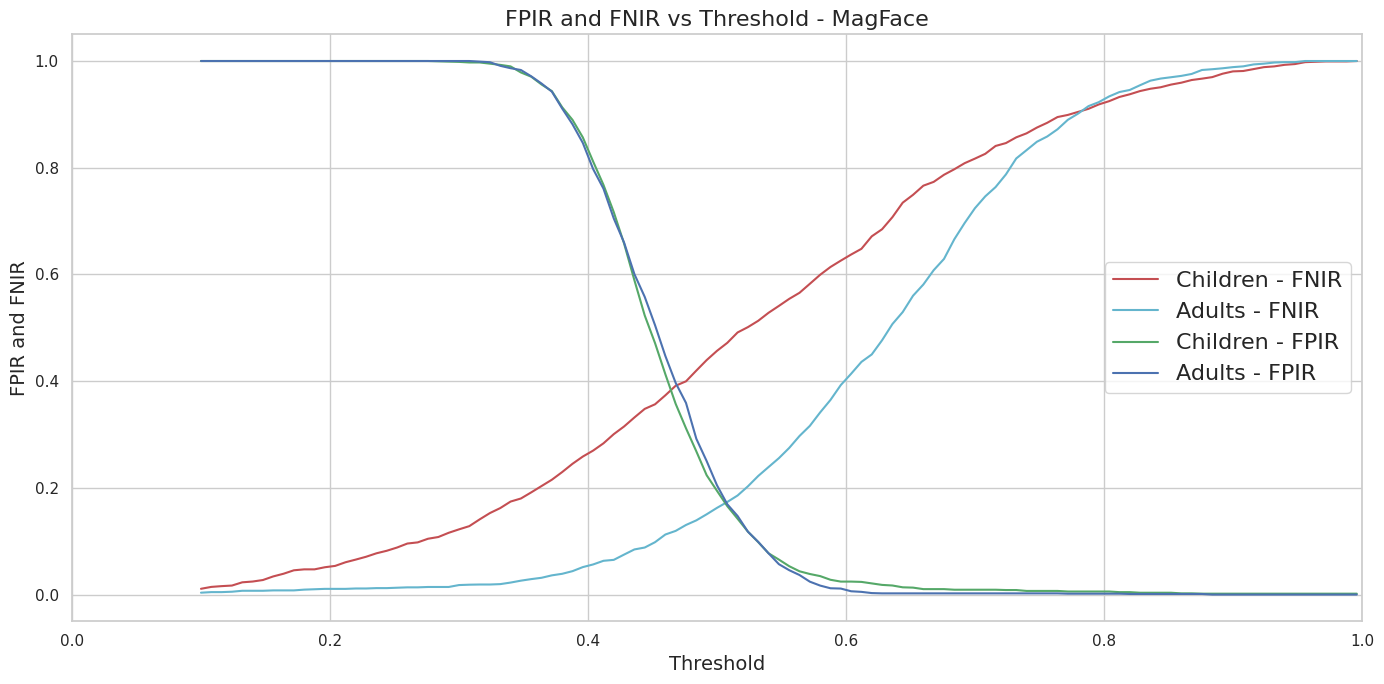

In [7]:

plot_threshold_metrics_ex_1_1_together(df_all_threshold_x, 'MagFace')

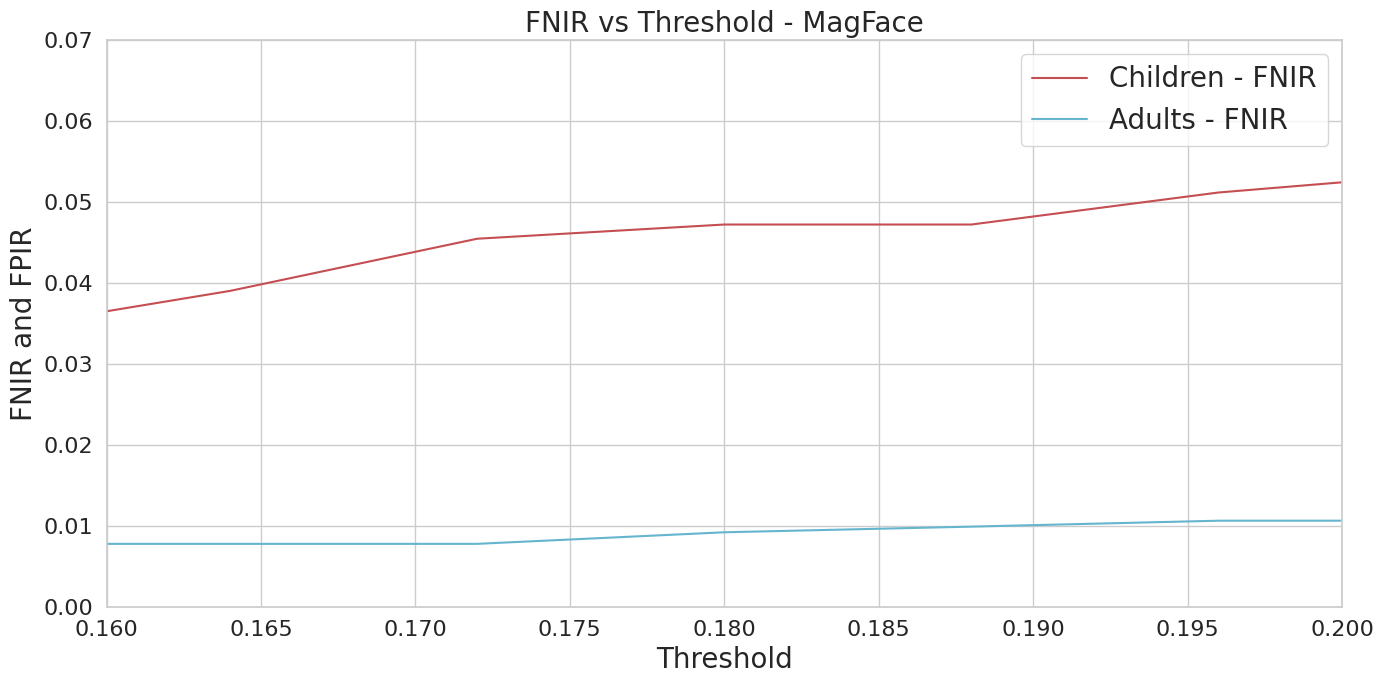

In [10]:
def plot_threshold_metrics_ex_1_1_zoomed(df_all_threshold_x):
    # Set the aesthetics for the plots
    sns.set(style="whitegrid")

    plot_df = df_all_threshold_x.groupby('Threshold').mean()

    plt.figure(figsize=(14, 7))
    plt.plot(plot_df.index, plot_df['FNIR_c'], 'r-', label='Children - FNIR')
    plt.plot(plot_df.index, plot_df['FNIR_a'], 'c-', label='Adults - FNIR')
    plt.xlabel('Threshold', fontsize=20)
    plt.ylabel('FNIR and FPIR', fontsize=20)
    plt.title('FNIR vs Threshold - MagFace', fontsize=20)
    plt.ylim(0.0, 0.07)  # Limit the FNIR y-axis
    plt.xlim(0.16, 0.20)
    plt.legend(fontsize=20)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid(True)

    plt.tight_layout()

    # Show the plot
    plt.show()
plot_threshold_metrics_ex_1_1_zoomed(df_all_threshold_x)

### the threshold should be 0.194

# Stats - 10 experiments

In [59]:

random_states = [11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

df_all_results, sim_mat_dict_all_magface_ex1_1 = evaluate_metrics_ex_1_1(
    random_states, children_all, adults_all, image_names_c, image_names_a,
    sim_mat_c, sim_mat_a, num_ids_c, num_ids_a, ids_c, ids_a, balance_child_data,
    balance_adults_data_enrolled, compute_fnir, compute_fpir, GARBE, remove_ones, 0.194
)


FPD result:  0.0
FND result:  0.3656933747174005
GARBE result, GARBE close to 1 means more unfair:  0.27427003103805037
done
FPD result:  0.0
FND result:  0.3152472837112844
GARBE result, GARBE close to 1 means more unfair:  0.2364354627834633
done
FPD result:  0.0
FND result:  0.3266832917705736
GARBE result, GARBE close to 1 means more unfair:  0.2450124688279302
done
FPD result:  0.0
FND result:  0.30059012474788976
GARBE result, GARBE close to 1 means more unfair:  0.22544259356091734
done
FPD result:  0.0
FND result:  0.386680883064973
GARBE result, GARBE close to 1 means more unfair:  0.29001066229872974
done
FPD result:  0.0
FND result:  0.3293703833978192
GARBE result, GARBE close to 1 means more unfair:  0.2470277875483644
done
FPD result:  0.0
FND result:  0.3626346842379519
GARBE result, GARBE close to 1 means more unfair:  0.2719760131784639
done
FPD result:  0.0
FND result:  0.338901065679087
GARBE result, GARBE close to 1 means more unfair:  0.25417579925931527
done
FPD r

In [60]:
df_all_results.applymap(lambda x: f"{x:.3f}")

/tmp/ipykernel_2363/2398388374.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
0,11.000,0.046,0.007,1.000,1.000,0.000,0.366,0.274,0.194
1,12.000,0.048,0.011,1.000,1.000,0.000,0.315,0.236,0.194
2,13.000,0.047,0.010,1.000,1.000,0.000,0.327,0.245,0.194
3,14.000,0.053,0.013,1.000,1.000,0.000,0.301,0.225,0.194
4,15.000,0.044,0.006,1.000,1.000,0.000,0.387,0.290,0.194
5,16.000,0.049,0.010,1.000,1.000,0.000,0.329,0.247,0.194
6,17.000,0.054,0.009,1.000,1.000,0.000,0.363,0.272,0.194
7,18.000,0.056,0.011,1.000,1.000,0.000,0.339,0.254,0.194
8,19.000,0.049,0.006,1.000,1.000,0.000,0.384,0.288,0.194
9,20.000,0.044,0.009,1.000,1.000,0.000,0.331,0.249,0.194


In [61]:
df_all_results.describe().applymap(lambda x: f"{x:.3f}")


/tmp/ipykernel_2363/1142005554.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_all_results.describe().applymap(lambda x: f"{x:.3f}")


,Iteration,FNIR_c,FNIR_a,FPIR_c,FPIR_a,FPD,FND,GARBE,Threshold
count,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000,10.000
mean,15.500,0.049,0.009,1.000,1.000,0.000,0.344,0.258,0.194
std,3.028,0.004,0.002,0.000,0.000,0.000,0.029,0.022,0.000
min,11.000,0.044,0.006,1.000,1.000,0.000,0.301,0.225,0.194
25%,13.250,0.046,0.007,1.000,1.000,0.000,0.327,0.246,0.194
50%,15.500,0.048,0.009,1.000,1.000,0.000,0.335,0.251,0.194
75%,17.750,0.052,0.011,1.000,1.000,0.000,0.365,0.274,0.194
max,20.000,0.056,0.013,1.000,1.000,0.000,0.387,0.290,0.194


# Gemmer simscores

In [62]:
df_all_results.to_csv('results_10_experiment_2_1_magface.csv')

In [63]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10
# List to hold all the arrays
sim_mat_c_enrolled_iterations = []

# Loop to access each array and append it to the list
for i in range(11, 21):
    key = f'sim_mat_c_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_c_enrolled_iterations_all = np.concatenate(sim_mat_c_enrolled_iterations)
sim_mat_c_enrolled_iterations_all = pd.DataFrame(sim_mat_c_enrolled_iterations_all)
sim_mat_c_enrolled_iterations_all.to_csv('sim_mat_c_enrolled_iterations_all_2_1_mag.csv', index=False)
# Print the big array
print(len(sim_mat_c_enrolled_iterations_all))



# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_enrolled_iterations = []

# Loop to access each array and append it to the list
# for i in range(1, 11):
for i in range(11, 21):
    key = f'sim_mat_a_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

# Concatenate all arrays into one big array
sim_mat_a_enrolled_iterations_all = np.concatenate(sim_mat_a_enrolled_iterations)
sim_mat_a_enrolled_iterations_all = pd.DataFrame(sim_mat_a_enrolled_iterations_all)
sim_mat_a_enrolled_iterations_all.to_csv('sim_mat_a_enrolled_iterations_all_2_1_mag.csv', index=False)


# Print the big array
print(len(sim_mat_a_enrolled_iterations_all))


97654
26400


In [64]:
# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_c_non_enrolled_iterations = []

# Loop to access each array and append it to the list
# for i in range(1, 11):
for i in range(11, 21):
    key = f'sim_mat_c_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_c_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_c_non_enrolled_iterations_all = np.concatenate(sim_mat_c_non_enrolled_iterations)
sim_mat_c_non_enrolled_iterations_all = pd.DataFrame(sim_mat_c_non_enrolled_iterations_all)
sim_mat_c_non_enrolled_iterations_all.to_csv('sim_mat_c_non_enrolled_iterations_all_2_1_mag.csv', index=False)
# Print the big array
print(len(sim_mat_c_non_enrolled_iterations_all))


# Add together all

# make one  big array out of all arays named f'sim_mat_dict_all_magface_ex1_1['sim_mat_c_enrolled_iteration_{i}']' for i from 1 to 10

# List to hold all the arrays
sim_mat_a_non_enrolled_iterations = []

# Loop to access each array and append it to the list
# for i in range(1, 11):
for i in range(11, 21):
    key = f'sim_mat_a_non_enrolled_iteration_{i}'
    if key in sim_mat_dict_all_magface_ex1_1:
        sim_mat_a_non_enrolled_iterations.append(sim_mat_dict_all_magface_ex1_1[key])

sim_mat_a_non_enrolled_iterations_all = np.concatenate(sim_mat_a_non_enrolled_iterations)
sim_mat_a_non_enrolled_iterations_all = pd.DataFrame(sim_mat_a_non_enrolled_iterations_all)
sim_mat_a_non_enrolled_iterations_all.to_csv('sim_mat_a_non_enrolled_iterations_all_2_1_mag.csv', index=False)

# Print the big array
print(len(sim_mat_a_non_enrolled_iterations_all))


20294495
20377521


# Loading pre-saved stuff

In [17]:
sim_mat_c_enrolled_iterations_all = (pd.read_csv('sim_mat_c_enrolled_iterations_all_2_1_mag.csv')).values.flatten()
sim_mat_a_enrolled_iterations_all = (pd.read_csv('sim_mat_a_enrolled_iterations_all_2_1_mag.csv')).values.flatten()
sim_mat_c_non_enrolled_iterations_all = (pd.read_csv('sim_mat_c_non_enrolled_iterations_all_2_1_mag.csv')).values.flatten()
sim_mat_a_non_enrolled_iterations_all = (pd.read_csv('sim_mat_a_non_enrolled_iterations_all_2_1_mag.csv')).values.flatten()


In [18]:
from scipy.stats import describe, gaussian_kde
import math

def descriptive_statistics(mated_scores, nonmated_scores):
    stats_labels = ["Observations", "Minimum", "Maximum", "Mean", "St. Dev.", "Skewness", "Ex. Kurtosis"]
    mated_stats = describe(mated_scores)
    mated_stats = [mated_stats.nobs, mated_stats.minmax[0], mated_stats.minmax[1], mated_stats.mean, math.sqrt(mated_stats.variance), mated_stats.skewness, mated_stats.kurtosis]
    nonmated_stats = describe(nonmated_scores)
    nonmated_stats = [nonmated_stats.nobs, nonmated_stats.minmax[0], nonmated_stats.minmax[1], nonmated_stats.mean, math.sqrt(nonmated_stats.variance), nonmated_stats.skewness, nonmated_stats.kurtosis]

    stats_system_df = pd.DataFrame(np.array([stats_labels, mated_stats, nonmated_stats]).T, columns=["Statistic", "Mated", "Non-mated"])
    stats_system_df = stats_system_df.astype({"Statistic": str, "Mated": float, "Non-mated": float})
    return stats_system_df

In [19]:
mated_scores1 = sim_mat_a_enrolled_iterations_all
nonmated_scores1 = sim_mat_a_non_enrolled_iterations_all
scores_type1 = "similarity"
stats_system1_df = descriptive_statistics(mated_scores1, nonmated_scores1)
display(stats_system1_df)

,Statistic,Mated,Non-mated
0,Observations,26498.000000,2.025881e+07
1,Minimum,-0.069577,-3.773855e-01
2,Maximum,0.967829,9.056183e-01
3,Mean,0.649043,8.839756e-02
4,St. Dev.,0.125800,1.036368e-01
5,Skewness,-0.673422,1.762471e-01
6,Ex. Kurtosis,1.627773,1.736434e-01


In [20]:
mated_scores2 = sim_mat_c_enrolled_iterations_all
nonmated_scores2 = sim_mat_c_non_enrolled_iterations_all
scores_type2 = "similarity"
stats_system2_df = descriptive_statistics(mated_scores2, nonmated_scores2)
display(stats_system2_df)

,Statistic,Mated,Non-mated
0,Observations,97188.000000,2.017143e+07
1,Minimum,-0.097575,-4.763026e-01
2,Maximum,0.997555,9.998955e-01
3,Mean,0.529599,5.352077e-02
4,St. Dev.,0.180643,1.151738e-01
5,Skewness,-0.179711,1.300952e-01
6,Ex. Kurtosis,-0.244004,1.456535e-02


In [21]:
mated_colour = "green"
mated_label = "Mated scores"
nonmated_colour = "red"
nonmated_label = "Non-mated scores"

figure_size = (12,6)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 16
label_fontsize = 20

threshold_colour = "black"
threshold_style = "--"
round_digits = 5
sns.set(style="white", palette="muted", color_codes=True)
plt.rc("axes", axisbelow=True)

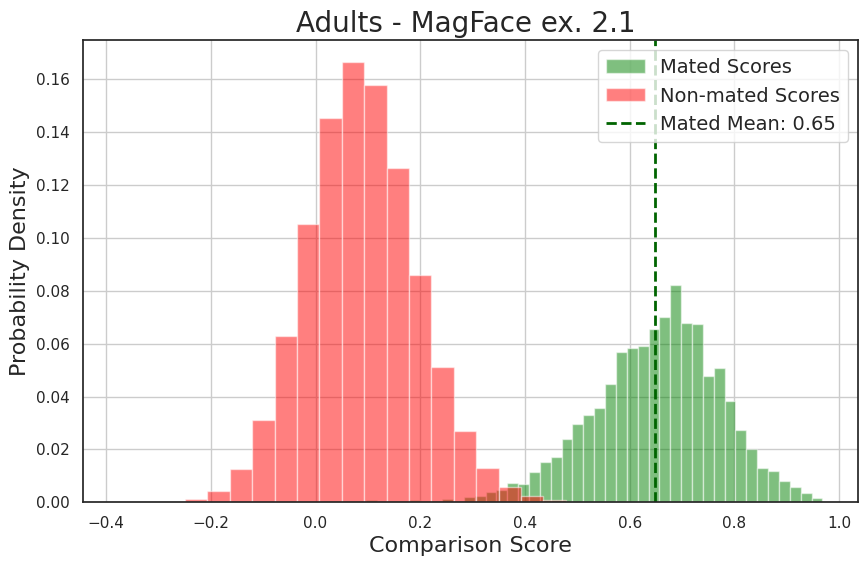

In [22]:

plot_histogram(mated_scores1, nonmated_scores1, normalise=True, title = 'Adults - MagFace ex. 2.1 ')


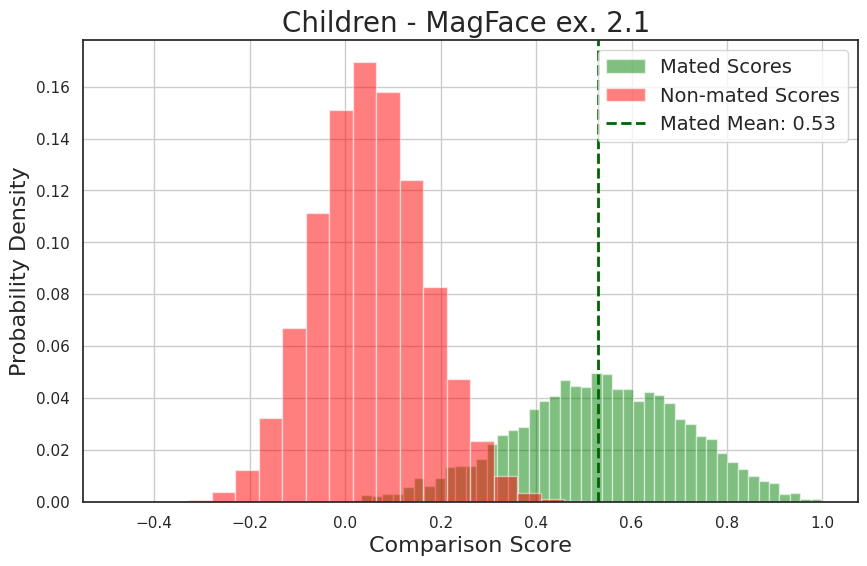

In [23]:
plot_histogram(mated_scores2, nonmated_scores2, normalise=True, title = 'Children - MagFace ex. 2.1 ')


# DET curves

In [24]:
d_prime_system1 = d_prime(mated_scores1, nonmated_scores1)
print("d' child =", round(d_prime_system1, round_digits))

d_prime_system2 = d_prime(mated_scores2, nonmated_scores2)
print("d' adult =", round(d_prime_system2, round_digits))

# d_prime_system3 = d_prime(mated_scores3, nonmated_scores3)
# print("d' canonical =", round(d_prime_system3, round_digits))


d' child = 4.86456
d' adult = 3.1427


In [15]:
# figure_size = (12,7)
# alpha_shade = 0.25
# alpha_fill = 1.0
# linewidth = 2
# legend_loc = "upper left"
# legend_anchor = (1.0, 1.02)
# legend_cols = 1
# legend_fontsize = 18
# label_fontsize = 18
# tick_fontsize = 18

# def kde_with_threshold(mated_scores, nonmated_scores, scores_type, threshold, savename=None):
#     linspace_items = 101
#     mated_kde, mated_pos, mated_min, mated_max = get_kde(mated_scores, linspace_items)
#     nonmated_kde, nonmated_pos, nonmated_min, nonmated_max = get_kde(nonmated_scores, linspace_items)

#     plt.figure(figsize=figure_size)
#     plt.xlabel("Comparison Score", size=label_fontsize)
#     plt.ylabel("Probability Density", size=label_fontsize)

#     def compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items):
#         if scores_type == "similarity":
#             if mated_min < threshold:
#                 mated_shade = np.linspace(threshold, mated_max, linspace_items)
#                 mated_fill = np.linspace(mated_min, threshold, linspace_items)
#             else:
#                 mated_shade = np.linspace(mated_min, mated_max, linspace_items)
#                 mated_fill = None
#             if nonmated_max > threshold:
#                 nonmated_shade = np.linspace(nonmated_min, threshold, linspace_items)
#                 nonmated_fill = np.linspace(threshold, nonmated_max, linspace_items)
#             else:
#                 nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
#                 nonmated_fill = None
#         elif scores_type == "dissimilarity":
#             if mated_max > threshold:
#                 mated_shade = np.linspace(mated_min, threshold, linspace_items)
#                 mated_fill = np.linspace(threshold, mated_max, linspace_items)
#             else:
#                 mated_shade = np.linspace(mated_min, mated_max, linspace_items)
#                 mated_fill = None
#             if nonmated_min < threshold:
#                 nonmated_shade = np.linspace(threshold, nonmated_max, linspace_items)
#                 nonmated_fill = np.linspace(nonmated_min, threshold, linspace_items)
#             else:
#                 nonmated_shade = np.linspace(nonmated_min, nonmated_max, linspace_items)
#                 nonmated_fill = None
#         else:
#             raise ValueError(f"Unknown type of comparison scores: {scores_type}")
#         return mated_shade, mated_fill, nonmated_shade, nonmated_fill

#     plt.plot(mated_pos, mated_kde(mated_pos), linewidth=linewidth, color=mated_colour, label=mated_label)
#     plt.plot(nonmated_pos, nonmated_kde(nonmated_pos), linewidth=linewidth, color=nonmated_colour, label=nonmated_label)

#     mated_shade, mated_fill, nonmated_shade, nonmated_fill = compute_fills(scores_type, mated_min, mated_max, nonmated_min, nonmated_max, linspace_items)

#     plt.fill_between(mated_shade, mated_kde(mated_shade), alpha=alpha_shade, color=mated_colour)
#     plt.fill_between(nonmated_shade, nonmated_kde(nonmated_shade), alpha=alpha_shade, color=nonmated_colour)

#     if mated_fill is not None:
#         plt.fill_between(mated_fill, mated_kde(mated_fill), alpha=alpha_fill, color=mated_colour)
#     if nonmated_fill is not None:
#         plt.fill_between(nonmated_fill, nonmated_kde(nonmated_fill), alpha=alpha_fill, color=nonmated_colour)

#     plt.axvline(threshold, linewidth=linewidth, linestyle=threshold_style, color=threshold_colour, label="Decision th")

#     plt.legend(loc=0)
#     red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_fill, label='False positives')
#     green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_fill, label='False negatives')
#     shaded_red_patch = mpatches.Patch(color=nonmated_colour, alpha=alpha_shade, label='True negatives')
#     shaded_green_patch = mpatches.Patch(color=mated_colour, alpha=alpha_shade, label='True positives')
#     current_handles, _ = plt.gca().get_legend_handles_labels()

#     plt.grid(True)
#     plt.legend(loc='upper right', bbox_to_anchor=legend_anchor, ncol=legend_cols, fontsize=legend_fontsize, handles=[green_patch, red_patch, shaded_green_patch, shaded_red_patch]+current_handles)
#     plt.xlim(-0.1, 1)
#     plt.ylim(0, None)
#     plt.xticks(fontsize=tick_fontsize)
#     plt.yticks(fontsize=tick_fontsize)

#     if savename is not None:
#         plt.savefig(savename, bbox_inches="tight")
#         plt.cla()
#         plt.clf()
#         plt.close()
#     else:
#         plt.show()


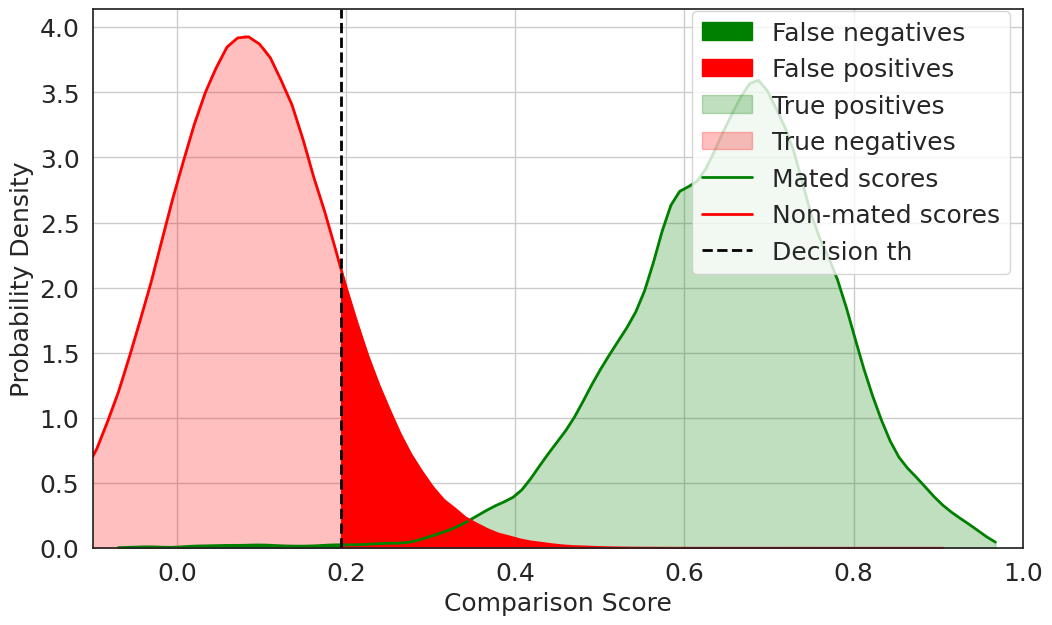

In [25]:
threshold1 = 0.194
kde_with_threshold(mated_scores1, nonmated_scores1, scores_type1, threshold1)

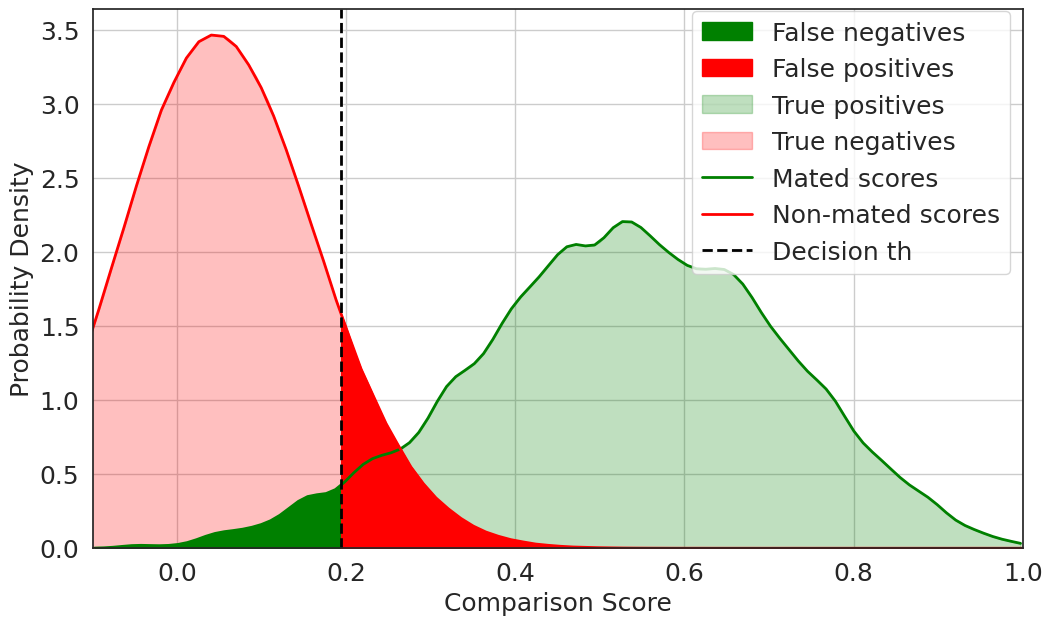

In [26]:
threshold2 = 0.194
kde_with_threshold(mated_scores2, nonmated_scores2, scores_type2, threshold2)

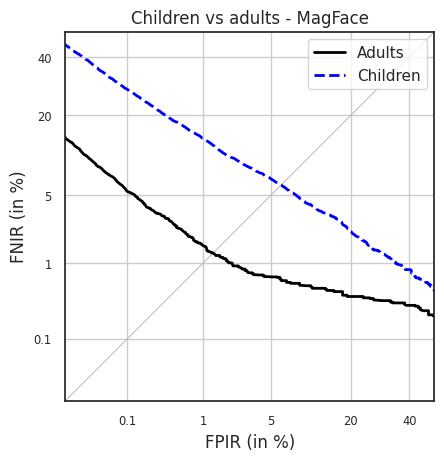

In [29]:
figure_size = (12,7)
alpha_shade = 0.25
alpha_fill = 1.0
linewidth = 2
legend_loc = "upper left"
legend_anchor = (1.0, 1.02)
legend_cols = 1
legend_fontsize = 18
label_fontsize = 18
tick_fontsize = 18


system_name1 = 'Adults'
system_name2 = 'Children'

det = DET(biometric_evaluation_type='identification', abbreviate_axes=True, plot_eer_line=True, plot_title="Children vs adults - MagFace")
det.x_limits = np.array([1e-4, .5])
det.y_limits = np.array([1e-4, .5])
det.x_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.x_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.y_ticks = np.array([1e-3, 1e-2, 5e-2, 20e-2, 40e-2])
det.y_ticklabels = np.array(['0.1', '1', '5', '20', '40'])
det.create_figure()
det.plot(tar=adjust_scores_for_DET(mated_scores1, scores_type1), non=adjust_scores_for_DET(nonmated_scores1, scores_type1), label=system_name1)
det.plot(tar=adjust_scores_for_DET(mated_scores2, scores_type2), non=adjust_scores_for_DET(nonmated_scores2, scores_type2), label=system_name2)
det.legend_on(loc="upper right")
# det.xticks(fontsize=tick_fontsize)
# det.yticks(fontsize=tick_fontsize)
det.show()